In [209]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, plot_tree

import graphviz
import shap
import matplotlib.pyplot as plt

In [215]:
df= pd.read_csv('speed_dating_data.csv')
df

,gender,age,income,goal,career,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,0,21.0,69487.0,2.0,lawyer,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,0,21.0,69487.0,2.0,lawyer,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
2,0,21.0,69487.0,2.0,lawyer,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0
3,0,21.0,69487.0,2.0,lawyer,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,0,21.0,69487.0,2.0,lawyer,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,3.0,5.0,5.0,5.0,NaN,NaN,2.0,5.0,0.0
8374,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,6.0,8.0,4.0,4.0,NaN,4.0,4.0,0.0
8375,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,7.0,8.0,8.0,8.0,NaN,6.0,5.0,0.0
8376,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,6.0,5.0,4.0,NaN,5.0,5.0,5.0,0.0


In [217]:
df.columns #target: dec features: income, attr, sinc, intel, fun, amb, 

Index(['gender', 'age', 'income', 'goal', 'career', 'dec', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met'],
      dtype='object')

In [99]:
len(df['career'].unique())

368

In [101]:
df.shape

(8378, 15)

In [103]:
df.dtypes

gender      int64
age       float64
income    float64
goal      float64
career     object
dec         int64
attr      float64
sinc      float64
intel     float64
fun       float64
amb       float64
shar      float64
like      float64
prob      float64
met       float64
dtype: object

In [221]:
df['id'] = df.set_index(['gender', 'age', 'income', 'career']).index.factorize()[0]+1

In [223]:
# dropping cols that are partner-dependent or have too many missings
df = df.drop(columns=['income', 'prob', 'shar', 'met', 'career'])

In [225]:
average_scores = df.groupby('id')[['attr', 'sinc', 'intel', 'fun', 'amb', 'like']].mean().reset_index()
df = df.groupby('id').first()
df = df.drop(columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'like']).join(average_scores.set_index('id'), on = 'id')
df

,gender,age,goal,dec,attr,sinc,intel,fun,amb,like
id,,,,,,,,,,
1,0,21.0,2.0,1,5.700000,7.300000,7.300000,6.800000,6.300000,6.500000
2,0,24.0,1.0,0,6.400000,7.000000,7.700000,6.100000,6.500000,6.600000
3,0,25.0,6.0,0,8.100000,8.600000,9.400000,7.700000,8.800000,8.200000
4,0,23.0,1.0,0,6.400000,8.900000,8.600000,7.800000,7.800000,6.600000
5,0,21.0,2.0,0,6.300000,6.000000,7.000000,6.000000,5.600000,7.200000
...,...,...,...,...,...,...,...,...,...,...
535,1,30.0,1.0,1,4.476190,6.714286,5.809524,4.476190,3.904762,5.047619
536,1,28.0,1.0,0,4.590909,7.045455,6.909091,6.727273,6.863636,5.363636
537,1,30.0,2.0,0,5.636364,5.954545,5.772727,5.500000,5.045455,5.500000


In [227]:
df.isna().sum()

gender    0
age       4
goal      3
dec       0
attr      0
sinc      1
intel     1
fun       1
amb       1
like      0
dtype: int64

In [229]:
df= df.dropna()

In [231]:
# Train Test Split

target = df['dec']
df= df.drop(columns= ['dec'])
features = df.select_dtypes(include=['number'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [173]:
normalizer = MinMaxScaler()

In [175]:
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [20]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,gender,age,goal,attr,sinc,intel,fun,amb,like
0,1.0,0.285714,0.2,0.653704,0.607966,0.620690,0.635611,0.686404,0.693309
1,1.0,0.476190,0.0,0.338889,0.591195,0.531034,0.552795,0.546053,0.451673
2,0.0,0.285714,0.0,0.633333,0.640252,0.605517,0.590062,0.522368,0.652416
3,0.0,0.142857,0.2,0.592593,0.930818,0.856705,0.468599,0.921053,0.625155
4,1.0,0.190476,1.0,0.388889,0.631027,0.477395,0.407867,0.388889,0.338910


In [233]:
# KNN

knn = KNeighborsClassifier(n_neighbors=5)

In [235]:
knn.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [239]:
pred = knn.predict(X_test_norm)  
y_test.values

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [241]:
knn.score(X_test_norm, y_test)

0.5607476635514018

In [243]:
# LOGISTIC REGRESSION 

lr = LogisticRegression()
lr.fit(X_train_norm, y_train)

LogisticRegression()

In [245]:
y_pred_lr = lr.predict(X_test_norm)

In [247]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr

0.6074766355140186

In [289]:
# DECISION TREE 

dt = DecisionTreeClassifier(random_state=0, max_depth=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=0)

In [291]:
y_pred_dt= dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_dt

0.5981308411214953

<class 'pandas.core.frame.DataFrame'>


[Text(0.5, 0.875, 'x[0] <= 0.5\ngini = 0.486\nsamples = 424\nvalue = [248, 176]'),
 Text(0.25, 0.625, 'x[7] <= 0.727\ngini = 0.437\nsamples = 214\nvalue = [145, 69]'),
 Text(0.125, 0.375, 'x[7] <= 0.658\ngini = 0.412\nsamples = 186\nvalue = [132.0, 54.0]'),
 Text(0.0625, 0.125, 'gini = 0.453\nsamples = 150\nvalue = [98, 52]'),
 Text(0.1875, 0.125, 'gini = 0.105\nsamples = 36\nvalue = [34, 2]'),
 Text(0.375, 0.375, 'x[5] <= 0.701\ngini = 0.497\nsamples = 28\nvalue = [13, 15]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.4375, 0.125, 'gini = 0.491\nsamples = 23\nvalue = [13.0, 10.0]'),
 Text(0.75, 0.625, 'x[3] <= 0.469\ngini = 0.5\nsamples = 210\nvalue = [103, 107]'),
 Text(0.625, 0.375, 'x[5] <= 0.249\ngini = 0.32\nsamples = 40\nvalue = [32, 8]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6875, 0.125, 'gini = 0.295\nsamples = 39\nvalue = [32, 7]'),
 Text(0.875, 0.375, 'x[8] <= 0.673\ngini = 0.486\nsamples = 170\nvalue = [71, 9

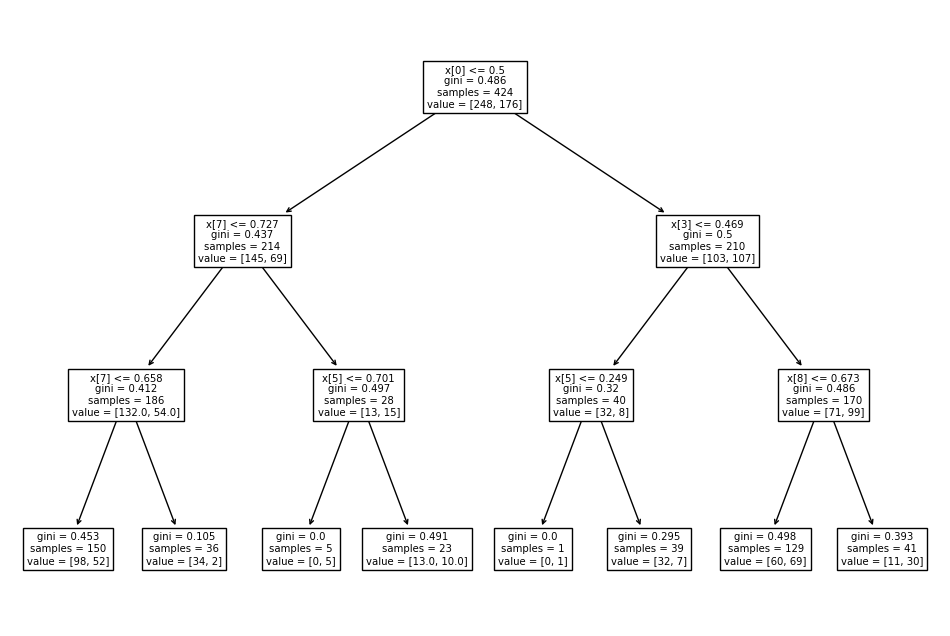

In [267]:
print(type(X_test))
plt.figure(figsize=(12, 8))
plot_tree(clf)

In [331]:
# RANDOM FOREST

rf= RandomForestClassifier(n_estimators=10, random_state=0, max_depth=3)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=0)

In [333]:
y_pred_rf= rf.predict(X_test)

In [335]:
accuracy_rf= accuracy_score(y_test, y_pred_rf)
accuracy_rf

0.6448598130841121

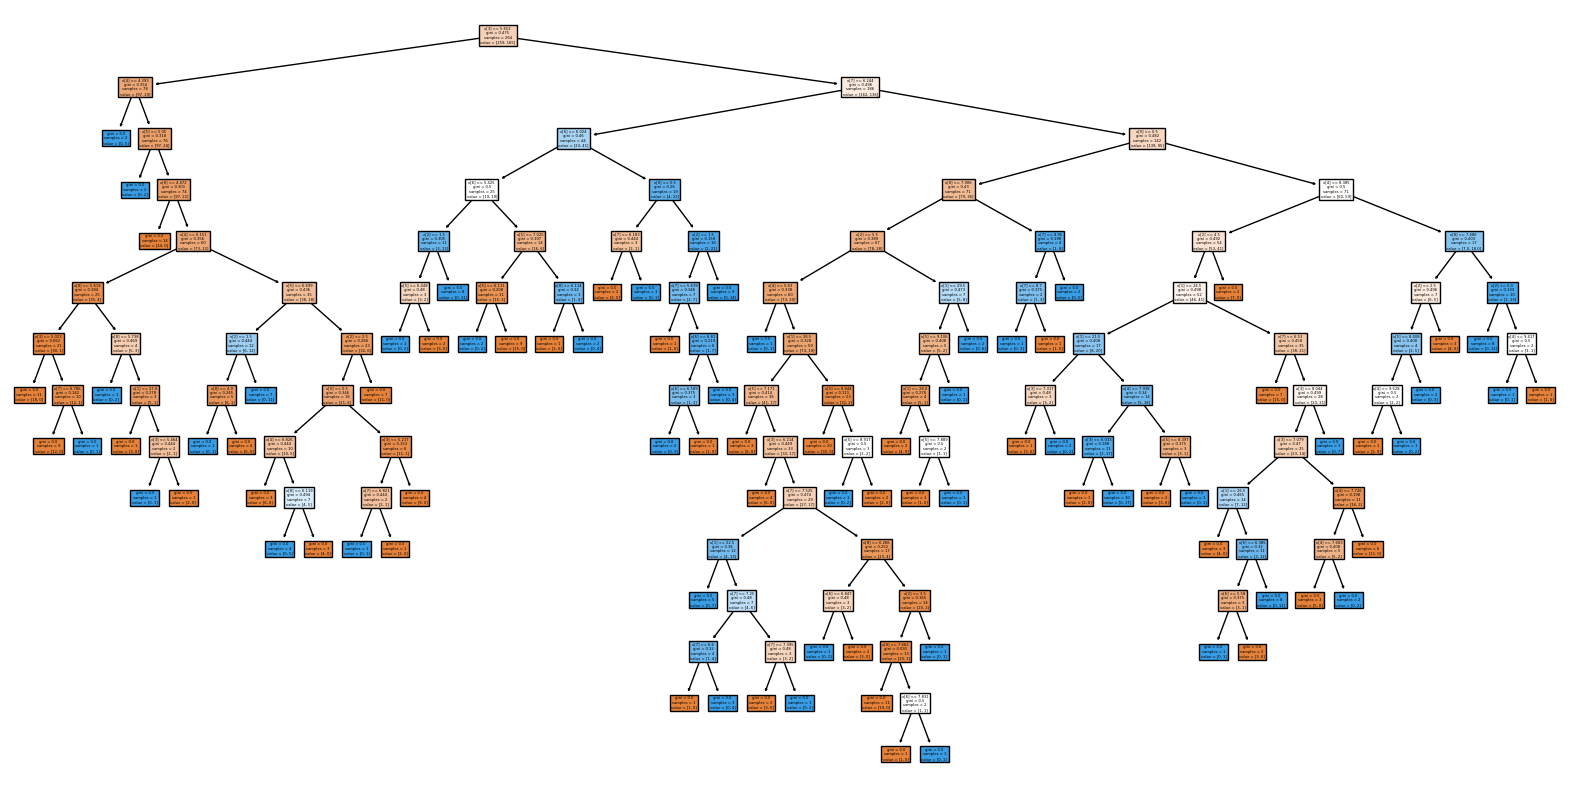

In [339]:
rf = RandomForestClassifier(n_estimators=10, random_state=0)
rf.fit(X_train, y_train)

# ONE TREE
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[9], filled=True)
plt.show()

In [343]:


for i in range(3):
    tree = rf.estimators_[i] 
    dot_data = export_graphviz(tree,
                               feature_names=X_test.columns,
                               filled=True,
                               max_depth=2, 
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)  
    display(graph) 

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH